## 最適化手法の実装

In [59]:
import numpy as np
from sympy import *
import seaborn as sns
from random import randrange
import matplotlib.pyplot as plt
%matplotlib inline

### 最小二乗法

課題の関数など必要な関数をそれぞれ定義する
$$ f(x_1,x_2) = 10 (x_1^2 - x_2)^2 + (x_1 - 1)^2 $$

In [2]:
# 関数
def f(x):
    return 10*(x[0]**2 - x[1])**2 + (x[0] - 1)**2

# 導関数
def df(x):
    return np.array([40*x[0]*(x[0]**2 - x[1]) + 2*x[0] - 2,
                     -20*x[0]**2 + 20*x[1]])
# ヘッセ行列
def hesse(x):
    return np.array([[float(120*x[0]**2 - 40*x[1] + 2),float(-40*x[0])],
                     [float(-40*x[0]),20]])
    
# Armijo条件
def armijo_method(x,d):
    g,t = 0.1,0.5 # 初期条件
    b = 1
    while f(x+b*d) >= f(x) + g*b*(np.dot(df(x).T,d)):
        b = b*t
    return b

# BFGS公式
def BFGS(beta,tmp_new,tmp):
    s = tmp_new - tmp
    y = df(tmp_new) - df(tmp)
    B_s,s_B_s,s_y = np.dot(beta,s),np.dot(np.dot(s.T,beta),s),np.dot(s.T,y)
    tmp_beta = beta - np.dot(B_s,B_s.T)/s_B_s + np.dot(y,y.T)/s_y
    return tmp_beta

初期値, 正定値対称な初期行列をそれぞれ定義する
$$
x_0 = 
\begin{bmatrix}
0 \\
2 
\end{bmatrix}
$$

$$
\beta_0 = 
\begin{bmatrix}
1 & -2 \\
-2 & 6
\end{bmatrix}
$$

In [3]:
# 初期値
start_point = np.array([[0],[2]])
# 正定値対称な初期行列
start_beta = np.array([[1,-2],[-2,6]])

最急降下法, ニュートン法, 準ニュートン法の関数をアルゴリズムに従って定義する.

In [4]:
# 最急降下法
def gradient_descent_method(point):
    eps  = 1e-5 # 終了条件
    tmp = point # 点の移動用
    history = point # 数値を記録
    iteration = 1000 # 最大繰り返し回数
    
    for i in range(iteration):
        d = -df(tmp) # 探索方向
        alpha = armijo_method(tmp,d) # ステップ幅
        tmp_new = tmp + alpha*d
        if np.abs(np.linalg.norm(tmp-tmp_new)) < eps:
            break
        tmp = tmp_new
        history = np.concatenate([history,tmp],axis = 1)
    return history.T

# ニュートン法
def newton_method(point):
    eps  = 1e-5 # 終了条件
    tmp = point # 点の移動用
    history = point # 数値を記録
    iteration = 1000 # 最大繰り返し回数
    for i in range(iteration):
        d = - np.dot(np.linalg.inv(hesse(tmp)),df(tmp)) # 探索方向
        tmp_new = tmp + d
        if np.abs(np.linalg.norm(tmp-tmp_new)) < eps:
            break
        tmp = tmp_new
        history = np.concatenate([history,tmp],axis = 1)        
    return history.T

# 準ニュートン法
def quasi_newton_method(point,beta):
    eps  = 1e-5 # 終了条件
    tmp = point # 点の移動用
    tmp_b = beta # 正定値行列の変更用
     
    history = point # 数値を記録
    iteration = 1000 # 最大繰り返し回数
    
    for i in range(iteration):
        d = - np.dot(np.linalg.inv(tmp_b),df(tmp)) # 探索方向
        alpha = armijo_method(tmp,d) # ステップ幅
        tmp_new = tmp + alpha*d
        if np.abs(np.linalg.norm(tmp-tmp_new)) < eps:
            break
        tmp_b = BFGS(tmp_b,tmp_new,tmp) # betaの更新
        tmp = tmp_new
        history = np.concatenate([history,tmp],axis = 1)        
    return history.T

In [5]:
data_gradient = gradient_descent_method(start_point)
data_newton = newton_method(start_point)
data_quasi_newton = quasi_newton_method(start_point,start_beta)

### 得られた数値データを関数に代入することで, 値の推移を視覚化する

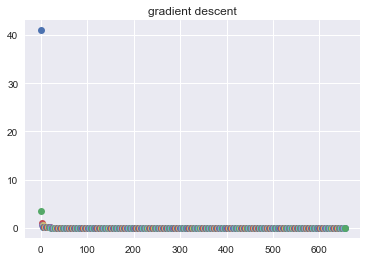

In [6]:
sns.plt.title('gradient descent')
for i in range(len(data_gradient)):
    plt.plot(i,f(data_gradient[i]),"o")

範囲が広すぎてよく分からないので繰り返し回数を30に変更してplot

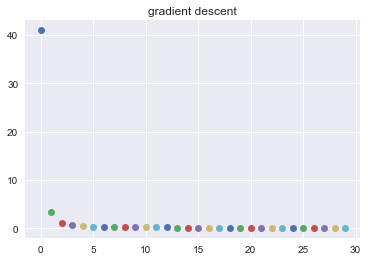

In [7]:
sns.plt.title('gradient descent')
for i in range(30):
    plt.plot(i,f(data_gradient[i]),"o")

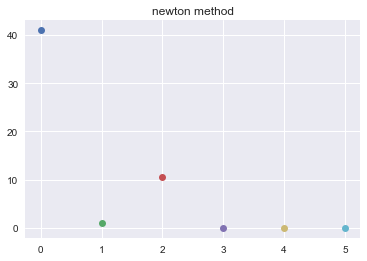

In [8]:
sns.plt.title('newton method')
for i in range(len(data_newton)):
    plt.plot(i,f(data_newton[i]),"o")

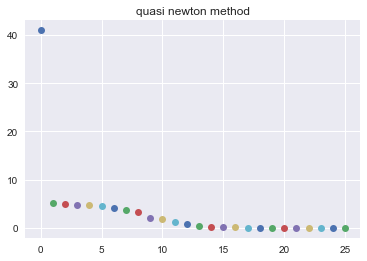

In [9]:
sns.plt.title('quasi newton method')
for i in range(len(data_quasi_newton)):
    plt.plot(i,f(data_quasi_newton[i]),"o")

### 回帰問題

回帰問題に対して, 確率的勾配降下法を実装する.

In [149]:
# 問題サンプルを作成する
def generate_train_data():
    ''' Create Train Data
    # y = x + 0 + e
    # e = N(0, 2) - normal distribution
    np.random.seed(10)  # For fix random values
    '''
    
    N = 1000
    alpha = 5
    beta  = 3
    e = np.random.normal(0, 3, N)
    x = np.random.normal(10,3,N)
    y = alpha*x + beta + e
    np.random.seed()
    np.random.seed()
    return np.c_[x,y]
# 散布図を作成する
def displayScatter(data):
    plt.figure(figsize=(9,6))
    plt.xlim(0, 22)
    plt.scatter(data[:,0],data[:,1], s=10, alpha=0.6)
# データをk個に分割
def cross_validation_split(data, n_folds):
    data_split = np.reshape(data,(n_folds,-1,data.shape[1]))
    return data_split
# 予測
def predict(row,coef):
    yhat = coef[0] # constant parameter
    for i in range(len(row)-1): # coefficients parameter
        yhat += coef[i+1] * row[i] 
    return yhat
# 係数パラメータを予測する
def coefficients_sgd(data, learning_rate, n_epoch):
    # learning_rate: 学習率, n_epoch: 反復回数
    coef = [0.0 for i in range(len(data[0]))]
    for epoch in range(n_epoch):
        sum_error = 0
        for row in data:
            yhat = predict(row, coef)
            error = yhat - row[-1] # y_hat - y
            sum_error += error**2 # 最小二乗誤差
            coef[0] = coef[0] - l_rate * error
            for i in range(len(row)-1):
                coef[i+1] = coef[i+1] - l_rate * error * row[i]
            # print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
    return coef
# SGDによる線形回帰
def linear_regression_sgd(train, test, l_rate, n_epoch):
    predictions = list()
    coef = coefficients_sgd(train, l_rate, n_epoch)
    for row in test:
        yhat = predict(row, coef)
        predictions.append(yhat)
    predictions = np.asarray(predictions)
    return(predictions,coef)
# main 関数
def main(data,n_folds,l_rate,n_epoch):
    # データを分割する
    data_split = cross_validation_split(data,n_folds)
    scores = list() # RMSEを格納する
    for fold in range(n_folds):
        # Testデータを除く
        train = np.delete(data_split,fold,axis=0)
        # 二次元配列に戻す
        train = np.reshape(train,(-1,data.shape[1]))
        # testデータを抽出
        test = data_split[0]
        # パラメータ推定
        pred,coef = linear_regression_sgd(train,test,l_rate, n_epoch)
        # RMSE
        rmse = np.sum(np.square(pred - test[:,1]))
        scores.append(rmse)
    return (scores,coef)

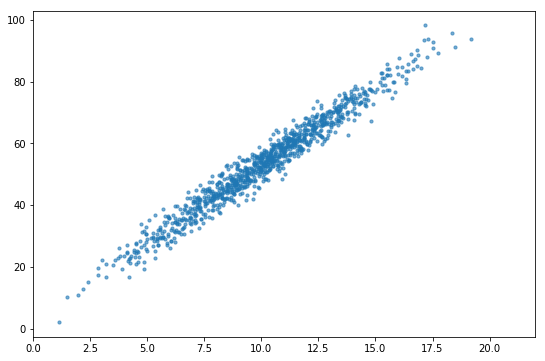

In [150]:
# データ生成
data = generate_train_data()
# 散布図
displayScatter(data)

In [153]:
# パラメータ
l_rate = 0.01
n_epoch = 200
n_folds = 5
# main 
scores,coef = main(data,n_folds,l_rate,n_epoch)
print('Mean RMSE: %.3f' % np.mean(scores))
print(coef)

Mean RMSE: 1722.207
[3.6757089760707533, 4.94013624058821]
